# Importing Libraries


In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.optim as optim
from torchvision import models

# Classification

create dataloaders

In [2]:
#define a transformation function for training and test
train_transformation = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

#create training and test dataset
training = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformation)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformation)

size_batch = 10000
#create training and test loaders
train_loader = torch.utils.data.DataLoader(training, batch_size=size_batch,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=size_batch,shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 74055656.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
'''
def check_class_distribution(loader, name):
    class_count = np.zeros(10)  #count occurrences of each class
    for _, labels in loader:
        for label in labels:
            class_count[label] += 1
    classes = [f"Class {i}" for i in range(10)]  #class labels
    plt.bar(classes, class_count)
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)  #better readability
    plt.show()

# Plot class distribution for training data
check_class_distribution(train_loader, "Training Data")

# Plot class distribution for test data
check_class_distribution(test_loader, "Test Data")
'''

'\ndef check_class_distribution(loader, name):\n    class_count = np.zeros(10)  #count occurrences of each class\n    for _, labels in loader:\n        for label in labels:\n            class_count[label] += 1\n    classes = [f"Class {i}" for i in range(10)]  #class labels\n    plt.bar(classes, class_count)\n    plt.title(f"Class Distribution in {name}")\n    plt.xlabel("Class")\n    plt.ylabel("Number of Samples")\n    plt.xticks(rotation=45)  #better readability\n    plt.show()\n\n# Plot class distribution for training data\ncheck_class_distribution(train_loader, "Training Data")\n\n# Plot class distribution for test data\ncheck_class_distribution(test_loader, "Test Data")\n'

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


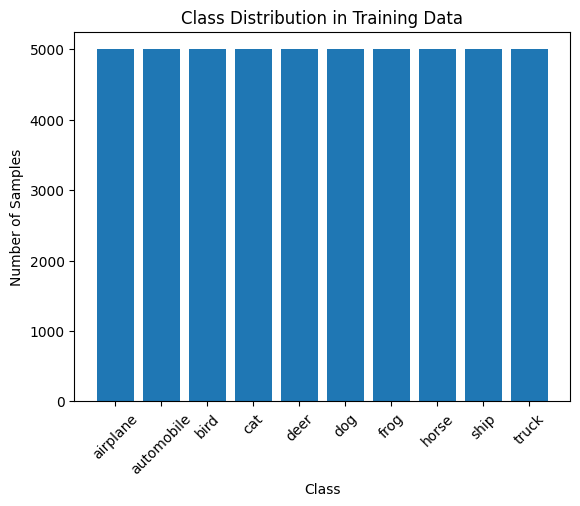

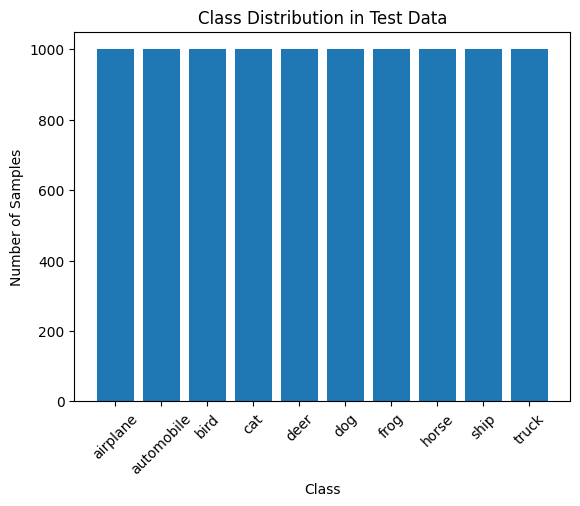

In [3]:
def check_class_distribution(dataset, loader, name):
    classes = dataset.classes
    num_classes = len(classes)
    class_count = np.zeros(10)  #count occurrences of each class
    shape_image = None
    for images, labels in loader:
        if shape_image is None:
            shape_image = images[0].shape
        for label in labels:
            class_count[label] += 1
    plt.bar(classes, class_count)
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)  #better readability
    plt.show()
    return shape_image, num_classes


#distribution for training data
shape_image_train, num_classes_train = check_class_distribution(training,train_loader, "Training Data")
#distribution for test data
shape_image_test, num_classes_test = check_class_distribution(test, test_loader, "Test Data")

In [4]:
#sanity check
if shape_image_train == shape_image_test:
  #input_size = torch.prod(torch.tensor(shape_image_train)).item()
  input_size = torch.tensor(shape_image_train)
if num_classes_train == num_classes_test:
  output_size = num_classes_train
print(input_size, output_size)
'''
print(int(input_size[0]))
print(int(input_size[1]))
print(int(input_size[2]))
'''

tensor([ 3, 32, 32]) 10


'\nprint(int(input_size[0]))\nprint(int(input_size[1]))\nprint(int(input_size[2]))\n'

In [ ]:
#'''
# class Trial_CIFAR10(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(input_size[0],input_size[1] , kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(input_size[1] ,input_size[1] , kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(input_size[1] * 8 * 8, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, output_size)

#     def forward(self, x):
#         #print("1",x.shape)
#         x = self.pool(F.relu(self.conv1(x)))
#         #print("2",x.shape)
#         x = self.pool(F.relu(self.conv2(x)))
#         #print("3",x.shape)
#         # Flatten images into vectors
#         x = x.view(x.size(0), -1)
#         #print("4",x.shape)
#         x = F.relu(self.fc1(x))
#         #print("5",x.shape)
#         x = F.relu(self.fc2(x))
#         #print("6",x.shape)
#         x = self.fc3(x)
#         #print("7",x.shape)
#         return x
'''
class Trial_CIFAR10(nn.Module):
    def __init__(self):
        super(Trial_CIFAR10, self).__init__()
        # First convolutional layer: input channels=3 (RGB), output channels=16, kernel size=3x3, padding=1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Max pooling layer: kernel size=2x2, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: input channels=16, output channels=32, kernel size=3x3, padding=1
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # First fully connected (linear) layer: input size=32*8*8 (output channels * height * width after pooling), output size=128
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        # Second fully connected layer: input size=128, output size=10 (number of classes)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Input x: batch of images, shape (batch_size, channels, height, width)
        # Apply first convolutional layer followed by ReLU activation
        print("1",x.shape)
        x = self.pool(torch.relu(self.conv1(x)))
        print("2",x.shape)
        # Apply second convolutional layer followed by ReLU activation
        x = self.pool(torch.relu(self.conv2(x)))
        print("3",x.shape)
        # Reshape the output to a 1D tensor for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        print("4",x.shape)
        # Apply first fully connected layer followed by ReLU activation
        x = torch.relu(self.fc1(x))
        print("5",x.shape)
        # Apply second fully connected layer (no activation function applied)
        x = self.fc2(x)
        print("6",x.shape)
        # Output x: raw scores/logits for each class, shape (batch_size, num_classes)
        return x
'''

'\nclass Trial_CIFAR10(nn.Module):\n    def __init__(self):\n        super(Trial_CIFAR10, self).__init__()\n        # First convolutional layer: input channels=3 (RGB), output channels=16, kernel size=3x3, padding=1\n        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)\n        # Max pooling layer: kernel size=2x2, stride=2\n        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)\n        # Second convolutional layer: input channels=16, output channels=32, kernel size=3x3, padding=1\n        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)\n        # First fully connected (linear) layer: input size=32*8*8 (output channels * height * width after pooling), output size=128\n        self.fc1 = nn.Linear(32 * 8 * 8, 256)\n        # Second fully connected layer: input size=128, output size=10 (number of classes)\n        self.fc2 = nn.Linear(256, 10)\n\n    def forward(self, x):\n        # Input x: batch of images, shape (batch_size, channels, height, width)\n        # A

In [5]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_device()
print(device)

cuda


In [ ]:
# model = Trial_CIFAR10()
# model.to(device)
# if next(model.parameters()).is_cuda:
#     print("model moved to cuda")

In [6]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False  # Freeze convolutional layers
num_ftrs = model.fc.in_features

# Add new final layers (replace with your architecture)

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, output_size)
)

model.to(device)

if next(model.parameters()).is_cuda:
    print("model moved to cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10) #number of epochs

In [ ]:
import sys
epochs = 10 #change it to whatever number you want
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs.shape)
        #print(labels.shape)
        #sys.exit()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #normalized_loss = loss.mean() / len(inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        #print(f'Epoch [{epoch + 1}/{5}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.3f}')
        if i == len(train_loader) - 1:  # If it's the last mini-batch
            # Print the average loss over the epoch
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {running_loss / (i + 1):.3f}')
            running_loss = 0.0
    scheduler.step(epoch-1)
print('Finished Training')


Epoch [1/10], Average Loss: 2.228


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/10], Average Loss: 1.980
Epoch [3/10], Average Loss: 1.849
Epoch [4/10], Average Loss: 1.783
Epoch [5/10], Average Loss: 1.731
Epoch [6/10], Average Loss: 1.708
Epoch [7/10], Average Loss: 1.691
Epoch [8/10], Average Loss: 1.683
Epoch [9/10], Average Loss: 1.671
Epoch [10/10], Average Loss: 1.669
Finished Training


In [ ]:
torch.save(model.state_dict(), 'resnet_original.pth')

# Attacks

In [ ]:
# Noise
def adversarial_noise(images, epsilon=100):
    """Add random adversarial noise to the images."""
    noise = epsilon * torch.randn_like(images) #random noise
    noised_images = images + noise # adding noise
    return torch.clamp(noised_images, 0, 255) # making sure pixel values are valid

In [6]:
# FGSM
def FGSM(model, image, epsilon=100):
    """
      The FGSM is an attack method designed to fool models by perturbing the input data slightly in a way that maximizes the loss.
      This function implements FGSM by taking a single image and its label, applying a gradient-based perturbation, and returning the modified image.
      The perturbation magnitude is controlled by `epsilon`, which determines how much to move along the gradient's sign direction.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.

    Output:
    - perturbed_image : The image tensor after the FGSM attack, perturbed such that it aims to maximize the classification loss.
"""
    image.requires_grad = True
    outputs = model(image)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    image_grad = image.grad.data
    sign_image_grad = image_grad.sign()
    perturbed_image = image + epsilon * sign_image_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)

    return perturbed_image

In [ ]:
# PGD
def PGD(model, image, epsilon=50,alpha = 100, num_iter = 100):
    """
    The Projected Gradient Descent is an iterative method used to create adversarial examples by subtly and incrementally changing an image to maximize model error.
    This function handles the attack by taking a single image and its label, applying small, controlled changes, and ensuring these changes stay within a defined limit, epsilon.
    The amount adjusted per step is set by alpha, and the process repeats for a specified number of iterations to refine the adversarial effect.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.
    - alpha : The step size for each iteration determining how much the image is modified at each step.
    - num-iter : The number of iterations to perform.

    Output:
    - perturbed_image : The image tensor after the PGD attack.
"""
    image.requires_grad = True
    criterion = nn.CrossEntropyLoss()
    for i in range(num_iter):
      outputs = model(image)
      loss = criterion(outputs, labels)
      model.zero_grad()
      loss.backward()
      image_grad = image.grad.data
      sign_image_grad = image_grad.sign()
      attacked_image = image + alpha * sign_image_grad
      dist = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

In [12]:
#JSM
def JSM(model, image, labels, max_iters = 100, threshold=0.1):
    """
    Jacobian-based Saliency Maps (JSM) explore the forward derivates to calculate the model gradients, replacing the
    gradient descent approaches, and discover which input regions are likely to yield adversarial examples.
    Then it uses saliency maps to construct the adversarial saliency maps, which display the features the adversary must perturb.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - max_iters (int): Maximum number of iterations for the attack.
    - labels : The true labels associated with the image tensor.
    - threshold (float): Threshold for pixel perturbation.

    Output:
    - perturbed_image : The image tensor after the JSM attack.
    """
    model.eval()
    image.requires_grad = True
    batch_size = image.size(0)

    for _ in range(max_iters):
        output = model(image)
        loss = F.cross_entropy(output,labels)
        model.zero_grad()
        loss.backward()

        saliency_map = image.grad.abs().sum(dim=1)
        perturb_mask = saliency_map > threshold
        perturb_values = torch.sign(image.grad) * perturb_mask.float().unsqueeze(1)
        image.data +=perturb_values
        image.grad.data.zero_()

    image = torch.clamp(image,0,1)
    return image


In [14]:
def FIA(model, image, target, epsilon=50, alpha=100, num_iter=50, drop_prob=0.3, ensemble_num=5):
    """
    Perform Feature Importance-aware Attack (FIA) considers the object-aware features that dominate the model decisions, using the aggregate
    gradient (gradients average concerning the feature maps). This approach avoids local optimum, represents transferable feature importance,
    and uses the aggregate gradient to assign weights identifying the essential features. Furthermore, FIA generates highly transferable
    adversarial examples when extracting the feature importance from multiple classification models.

    Parameters:
    - model: the neural network model (PyTorch model).
    - image: input image tensor
    - target: true label of the image.
    - epsilon: maximum perturbation.
    - alpha: step size for each iteration.
    - num_iter: number of iterations.
    - drop_prob: probability of dropping a pixel.
    - ensemble_num: number of random masks used to compute aggregate gradient.

    Returns:
    - perturbed_image: adversarially perturbed image.
    """
    # Ensuring computation is in evaluation mode to deactivate dropout layers
    model.eval()

    # Initializing perturbation to zero
    perturbation = torch.zeros_like(image)

    # Looping over the number of iterations
    for _ in range(num_iter):
        # Initializing aggregate gradients to zero
        aggregate_gradients = torch.zeros_like(image)

        # Generating multiple masked versions of the image
        for _ in range(ensemble_num):
            # Applying random pixel dropping
            mask = (torch.rand_like(image) > drop_prob).float()
            masked_image = image * mask
            masked_image.requires_grad = True

            # Forward pass
            output = model(masked_image)
            loss = nn.CrossEntropyLoss()(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculating gradients of model in backward pass
            loss.backward()

            # Accumulating the gradients
            aggregate_gradients += masked_image.grad.data

        # Averaging the gradients over all masked versions
        aggregate_gradients /= ensemble_num

        # Sign of the aggregated gradients
        grad_sign = aggregate_gradients.sign()

        # Updating the perturbation by a small step in the opposite direction of the gradient
        perturbation += alpha * grad_sign
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)

    # Apply the perturbation to the original image and clip to maintain valid pixel range
    perturbed_image = image + perturbation
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


In [7]:
def adversarial_examples(model, dataloader):
    """Testing the model with adversarial examples and print loss values."""
    total_orig = 0
    correct_orig = 0
    correct_predictions = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # adversarial examples
        # adv_images = adversarial_noise(images)
        # adv_images2 = FGSM(model,images)
        # adv_images3 = PGD(model,images)
        adv_images4 = JSM(model,images,labels)
        #adv_image5 = deepfool(model,images, labels)

        # original and attacked output label
        outputs_orig = model(images)
        # outputs_adv = model(adv_images)
        # outputs_adv2 = model(adv_images2)
        # outputs_adv3 = model(adv_images3)
        outputs_adv4 = model(adv_images4)
        # loss
        loss_orig = F.cross_entropy(outputs_orig, labels)
        # loss_adv = F.cross_entropy(outputs_adv, labels)
        # loss_adv2 = F.cross_entropy(outputs_adv2, labels)
        # loss_adv3 = F.cross_entropy(outputs_adv3, labels)
        loss_adv4 = F.cross_entropy(outputs_adv4, labels)
        # labels and loss values
        print("Original labels: ", labels.cpu().numpy())
        print("Loss on original images: ", loss_orig.item())
        # print("Loss on noisy adversarial images: ", loss_adv.item())
        # print("Loss on FGSM images: ", loss_adv2.item())
        # print("Loss on PGD images: ", loss_adv3.item())
        print("Loss on JSM images", loss_adv4.item())

        _, predicted_orig = torch.max(outputs_orig.data,1)
        total_orig += labels.size(0)
        correct_orig += (predicted_orig == labels).sum().item()

        # correct_predictions_original = torch.eq(predicted_original,labels).sum().item()
        # accuracy_original = correct_predictions_original / len(labels)

        _, predicted = torch.max(outputs_adv4.data, 1)

        correct_predictions  += (predicted == labels).sum().item()

    accuracy_original = 100 * correct_orig / len(labels)
    accuracy = 100 * correct_predictions / len(labels)
    print(f"Original Accuracy: {accuracy_original}")

    print(f"JSM Accuracy: {accuracy}")

    print(f"Predicted Label for Adversarial Image: {predicted.cpu().numpy()}")

    print("loss on JSM", loss_adv4)

In [15]:
def adversarial_examples(model, dataloader):
    """Testing the model with adversarial examples and print loss values."""
    total_orig = 0
    correct_orig = 0
    correct_predictions = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # adversarial examples
        # adv_images = adversarial_noise(images)
        # adv_images2 = FGSM(model,images)
        # adv_images3 = PGD(model,images)
        # adv_images4 = JSM(model,images,labels)
        adv_images5 = FIA(model,images, labels)

        # original and attacked output label
        outputs_orig = model(images)
        # outputs_adv = model(adv_images)
        # outputs_adv2 = model(adv_images2)
        # outputs_adv3 = model(adv_images3)
        # outputs_adv4 = model(adv_images4)
        outputs_adv5 = model(adv_images5)
        # loss
        loss_orig = F.cross_entropy(outputs_orig, labels)
        # loss_adv = F.cross_entropy(outputs_adv, labels)
        # loss_adv2 = F.cross_entropy(outputs_adv2, labels)
        # loss_adv3 = F.cross_entropy(outputs_adv3, labels)
        # loss_adv4 = F.cross_entropy(outputs_adv4, labels)
        loss_adv5 = F.cross_entropy(outputs_adv5, labels)
        # labels and loss values
        print("Original labels: ", labels.cpu().numpy())
        print("Loss on original images: ", loss_orig.item())

        # print("Loss on noisy adversarial images: ", loss_adv.item())
        # print("Loss on FGSM images: ", loss_adv2.item())
        # print("Loss on PGD images: ", loss_adv3.item())
        # print("Loss on JSM images", loss_adv4.item())

        print(f"Loss on FIA images: {loss_adv5.item()}")

        # prediction
        # _, predicted_adv = torch.max(outputs_adv.data,1
        _, predicted_orig = torch.max(outputs_orig.data,1)
        total_orig += labels.size(0)
        correct_orig += (predicted_orig == labels).sum().item()

        # correct_predictions_original = torch.eq(predicted_original,labels).sum().item()
        # accuracy_original = correct_predictions_original / len(labels)

        # _, predicted = torch.max(outputs_adv4.data, 1)
        _, predicted5 = torch.max(outputs_adv5.data, 1)

        # correct_predictions  += (predicted == labels).sum().item()
        correct_predictions_5 = (predicted5 == labels).sum().item()
    accuracy_original = 100 * correct_orig / len(labels)
    # accuracy = 100 * correct_predictions / len(labels)
    accuracy5 = 100 * correct_predictions_5 / len(labels)
    print(f"Original Accuracy: {accuracy_original}")

    # print(f"JSM Accuracy: {accuracy}")
    print(f"FIA Accuracy: {accuracy5}")
    # print(f"Predicted Label for Adversarial Image: {predicted.cpu().numpy()}")
    print(f"Predicted Label for Adversarial Image: {predicted5.cpu().numpy()}")

    print("loss on FIA", loss_adv5)

In [ ]:
# Test the model with adversarial examples
adversarial_examples(model, test_loader)

# Defense Methods

In [8]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False  # Freeze convolutional layers
num_ftrs = model.fc.in_features

# Add new final layers (replace with your architecture)

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, output_size)
)

model.to(device)

if next(model.parameters()).is_cuda:
    print("model moved to cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


model moved to cuda


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10) #number of epochs

In [10]:
import sys
import torch

epochs = 10
lambda_reg = 0.01
epsilon = 10  # Perturbation magnitude for adversarial training
clip_value = 1.0  # Gradient clipping value

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate adversarial examples by adding small perturbations
        inputs.requires_grad = True
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss.backward()

        # Calculate L2 Regularization on all parameters
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += lambda_reg * l2_reg

        #applying gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients for the second pass
        loss.backward(retain_graph=True)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i == len(train_loader) - 1:  # If it's the last mini-batch
            # Print the average loss over the epoch
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {running_loss / (i + 1):.3f}')
            running_loss = 0.0
    scheduler.step(epoch-1)

print('Finished Training')


Epoch [1/10], Average Loss: 7.122


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/10], Average Loss: 6.858
Epoch [3/10], Average Loss: 6.752
Epoch [4/10], Average Loss: 6.692
Epoch [5/10], Average Loss: 6.660
Epoch [6/10], Average Loss: 6.629
Epoch [7/10], Average Loss: 6.608
Epoch [8/10], Average Loss: 6.597
Epoch [9/10], Average Loss: 6.585
Epoch [10/10], Average Loss: 6.590
Finished Training


In [ ]:
torch.save(model.state_dict(), 'resnet_l2reg.pth')

In [16]:
adversarial_examples(model, test_loader)

Original labels:  [3 8 8 ... 5 1 7]
Loss on original images:  1.5723885297775269
Loss on FIA images: 2.650621175765991
Original Accuracy: 44.34
FIA Accuracy: 9.68
Predicted Label for Adversarial Image: [2 2 2 ... 2 2 2]
loss on FIA tensor(2.6506, device='cuda:0', grad_fn=<NllLossBackward0>)
